# Conservative remapping

In [1]:
import xgcm
import xarray as xr
import numpy as np
import xbasin
from matplotlib import pyplot as plt
import cmocean

We open the example data and create 2 grids: 1 for the dataset we have and 1 for the remapped one.
Here '_fr' means *from* and '_to' *to* (i.e. remapped data).

The grid difference between the 2 dataset comes from the using of the 3d scale factors (output of the model) or
a 1d version (remapped data) that corresponds to a z coordinate.

In [2]:
ds = xr.open_dataset('../xbasin/tests/data/nemo_full_dataset.nc')

metrics_fr = {
    ('X',): ['e1t', 'e1u', 'e1v', 'e1f'],
    ('Y',): ['e2t', 'e2u', 'e2v', 'e2f'],
    ('Z',): ['e3t', 'e3u', 'e3v', 'e3w']
}
metrics_to = {
    ('X',): ['e1t', 'e1u', 'e1v', 'e1f'],
    ('Y',): ['e2t', 'e2u', 'e2v', 'e2f'],
    ('Z',): ['e3t_1d', 'e3w_1d']
}
grid_fr = xgcm.Grid(ds, periodic=False, metrics=metrics_fr)
grid_to = xgcm.Grid(ds, periodic=False, metrics=metrics_to)

print(ds)

<xarray.Dataset>
Dimensions:        (axis_nbounds: 2, t: 1, x_c: 20, x_f: 20, y_c: 40, y_f: 40, z_c: 36, z_f: 36)
Coordinates:
  * z_f            (z_f) float64 -0.5 0.5 1.5 2.5 3.5 ... 31.5 32.5 33.5 34.5
  * t              (t) object 1050-07-01 00:00:00
  * x_c            (x_c) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
  * y_c            (y_c) int64 0 1 2 3 4 5 6 7 8 ... 31 32 33 34 35 36 37 38 39
  * z_c            (z_c) int64 0 1 2 3 4 5 6 7 8 ... 27 28 29 30 31 32 33 34 35
  * x_f            (x_f) float64 0.5 1.5 2.5 3.5 4.5 ... 16.5 17.5 18.5 19.5
  * y_f            (y_f) float64 0.5 1.5 2.5 3.5 4.5 ... 36.5 37.5 38.5 39.5
Dimensions without coordinates: axis_nbounds
Data variables:
    depthw_bounds  (z_f, axis_nbounds) float32 ...
    t_bounds       (t, axis_nbounds) object ...
    e3w            (t, z_f, y_c, x_c) float64 ...
    woce           (t, z_f, y_c, x_c) float64 ...
    deptht_bounds  (z_c, axis_nbounds) float32 ...
    e3t            (t, z_c, y_c, x_c) f

## Remap a T point

We use the `xbasin.remap_vertical` function, providing the xarray.dataArray, and the xgcm.Grid
corresponding to the levels before and after remapping.

In [3]:
%timeit xbasin.remap_vertical(ds.thetao, grid_fr, grid_to, axis='Z')

7.66 ms ± 57 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [4]:
theta_to = xbasin.remap_vertical(ds.thetao, grid_fr, grid_to, axis='Z')
s_to = xbasin.remap_vertical(ds.so, grid_fr, grid_to, axis='Z')
print(theta_to.coords)

Coordinates:
  * z_c      (z_c) int64 0 1 2 3 4 5 6 7 8 9 ... 26 27 28 29 30 31 32 33 34 35
  * t        (t) object 1050-07-01 00:00:00
  * x_c      (x_c) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
  * y_c      (y_c) int64 0 1 2 3 4 5 6 7 8 9 ... 30 31 32 33 34 35 36 37 38 39


The total heat content is conserved (this is mathematicaly true from the remapping method,
neglecting the error of the computer):

In [5]:
hc_fr = grid_fr.integrate(ds.thetao, axis='Z')
hc_to = grid_to.integrate(theta_to, axis='Z')

(hc_fr == hc_to).all()

<xarray.DataArray ()>
array(True)

Text(0.5, 1.0, 'Remapped data')

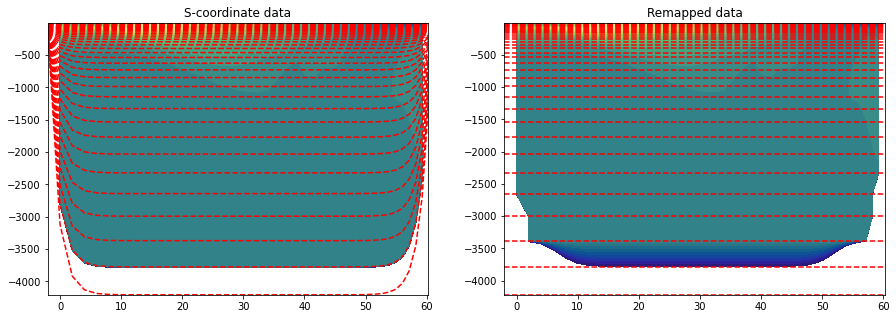

In [6]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

levels = np.linspace(35,37,21)

ctf0 = ax[0].contourf(
    ds.z_c*0+ds.gphit.isel({'x_c':10}),
    -ds.gdept_0.isel({'x_c':10}),
    ds.so.isel({'t':0, 'x_c':10}),
    levels=levels,
    cmap=cmocean.cm.haline
)

ctf1 = ax[1].contourf(
    ds.gphit.isel({'x_c':10}),
    -ds.gdept_1d,
    s_to.isel({'t':0, 'x_c':10}),
    levels=levels,
    cmap=cmocean.cm.haline
)

ax[0].plot(ds.gphit.isel({'x_c':10}), -ds.gdept_0.isel({'x_c':10}).T, 'r--')
ax[1].plot(ds.gphit.isel({'x_c':10}), ds.gphit.isel({'x_c':10})*0-ds.gdept_1d, 'r--')

ax[0].set_title('S-coordinate data')
ax[1].set_title('Remapped data')

(35.8, 36.8)

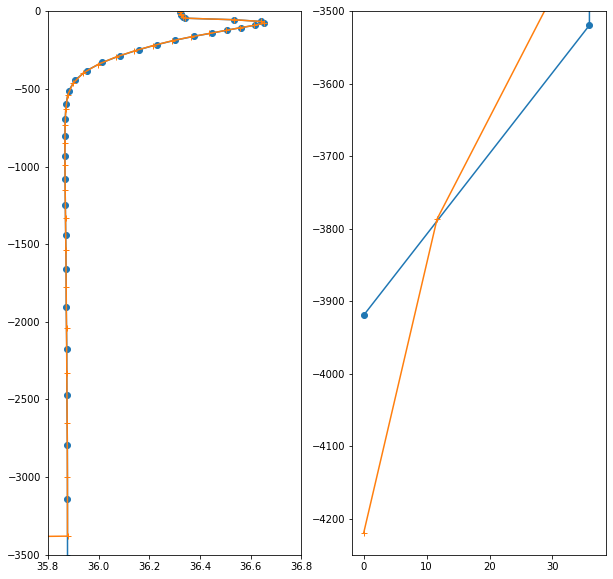

In [7]:
fig, ax = plt.subplots(1,2, sharex=False, figsize=(10,10))
x=10
y=2
for axe in ax:
    axe.plot(ds.so.isel({'t':0,'x_c':x, 'y_c':y}), -ds.gdept_0.isel({'x_c':x, 'y_c':y}), 'o-')
    axe.plot(s_to.isel({'t':0,'x_c':x, 'y_c':y}), -ds.gdept_1d, '+-')
    
cut = -3500
ax[0].set_ylim(cut,0)
ax[1].set_ylim(-4250, cut)

ax[0].set_xlim(35.8,36.8)

## Remap a W point

The usage is the same as for a T point. We verify the vertical integral with a plot.

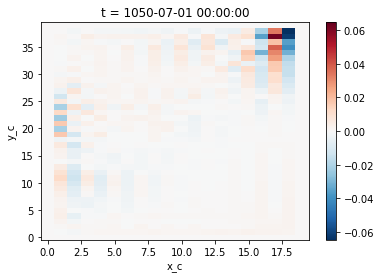

In [8]:
w_to = xbasin.remap_vertical(ds.woce, grid_fr, grid_to, axis='Z')
grid_to.integrate(w_to, axis='Z')[-1].plot()

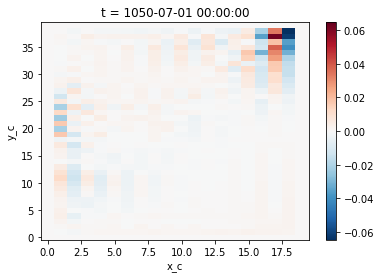

In [9]:
grid_fr.integrate(ds.woce, axis='Z')[-1].plot()

# Time comparison

The heart function of the remapping is transcoded from python to C++ with pythran, which improves the speed. However if pythran is not installed, the original python function is called instead.
As a user, **you should not use the 2 following functions**, they are only shown here for the time comparison.

In [10]:
fake_dataset = [
    np.ascontiguousarray(ds.gdept_0.values.reshape(ds.gdept_0.values.shape+(1,))),
    np.ascontiguousarray(ds.gdepw_0.values.reshape(ds.gdepw_0.values.shape+(1,))),
    np.ascontiguousarray(ds.thetao.transpose('z_c', 'y_c', 'x_c', 't').values.flatten().reshape(ds.thetao.transpose('z_c', 'y_c', 'x_c', 't').shape)[...,0:1])
]
from xbasin._interpolation import interp_new_vertical as _interpolation_pure_python
from xbasin.interpolation_compiled import interp_new_vertical as _interpolation_pythran

### Pure Python

In [11]:
%timeit _interpolation_pure_python(*fake_dataset)

132 ms ± 15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Pythran

In [ ]:
%timeit _interpolation_pythran(*fake_dataset)

We see that the compiled version runs about 10-100 times faster (of course this number is just a rough approximation that just take into account the cost of the heart function). The pure Python version does not use vectorized arrays and is thus slower.